<a href="https://colab.research.google.com/github/brainmentorspvtltd/IGDTU_PyTorchTraining/blob/main/IG_SimpleAutoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torch

In [2]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5,), (0.5))
])

train_data = torchvision.datasets.MNIST('dataset/train', train=True,
                                        transform = transforms,
                                        download=True)

test_data = torchvision.datasets.MNIST('dataset/test', train=False,
                                        transform = transforms,
                                        download=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 108425660.89it/s]


Extracting dataset/train/MNIST/raw/train-images-idx3-ubyte.gz to dataset/train/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 94269022.43it/s]

Extracting dataset/train/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/train/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 25002589.94it/s]


Extracting dataset/train/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/train/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 17721422.11it/s]


Extracting dataset/train/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/train/MNIST/raw



100%|██████████| 9912422/9912422 [00:00<00:00, 63736417.43it/s]


Extracting dataset/test/MNIST/raw/train-images-idx3-ubyte.gz to dataset/test/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 44617198.46it/s]


Extracting dataset/test/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/test/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 23989605.49it/s]


Extracting dataset/test/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/test/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 7111059.64it/s]

Extracting dataset/test/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/test/MNIST/raw



In [3]:
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=64
)

test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=64
)

In [4]:
train_data[0][0].numpy().shape

(1, 28, 28)

In [5]:
random_samples = np.random.randint(0,len(train_data), 25)

In [6]:
random_samples

array([36671, 50136, 48942,  9057, 14214, 17690, 58805, 18468,  9976,
       26864,  8190, 19568, 39608, 59864, 53670,  6372,  1373,  7702,
       37692, 42729, 46112, 30044, 32887, 52204, 10535])

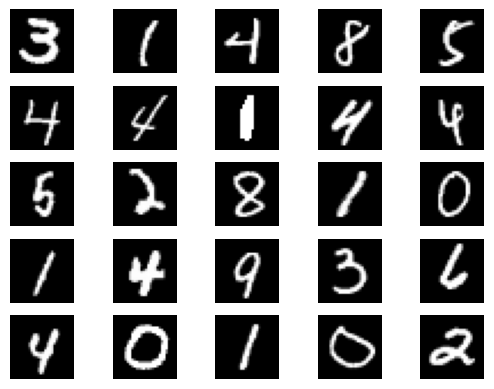

In [7]:
for i, img_indx in enumerate(random_samples):
  plt.subplot(5,5, i+1)
  plt.imshow(train_data[img_indx][0][0], cmap="gray")
  plt.axis('off')

plt.show()

In [8]:
class AutoEncoders(torch.nn.Module):
  def __init__(self, image_size=28):
    super().__init__()
    N = image_size ** 2 # 784 for MNIST data
    self.encoder = torch.nn.Sequential(
        torch.nn.Linear(N, 256),
        torch.nn.ReLU(),
        torch.nn.Linear(256, 128),
        torch.nn.ReLU(),
        torch.nn.Linear(128, 64),
        torch.nn.ReLU(),
        torch.nn.Linear(64, 10),
    )

    self.decoder = torch.nn.Sequential(
        torch.nn.Linear(10, 64),
        torch.nn.ReLU(),
        torch.nn.Linear(64, 128),
        torch.nn.ReLU(),
        torch.nn.Linear(128, 256),
        torch.nn.ReLU(),
        torch.nn.Linear(256, N),
        torch.nn.Sigmoid()
    )

  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [9]:
model = AutoEncoders()

In [18]:
model.to('cuda')

AutoEncoders(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=10, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=784, bias=True)
    (7): Sigmoid()
  )
)

In [15]:
!pip install torchview

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [12]:
# !pip install graphviz

In [13]:
import graphviz

graphviz.set_jupyter_format('png')

'svg'

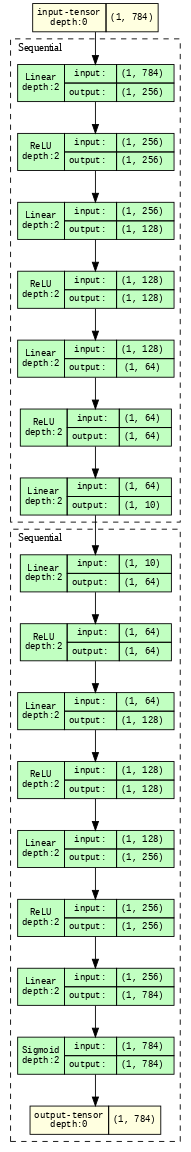

In [16]:
from torchview import draw_graph

model_graph = draw_graph(model, input_size=(1,28*28), expand_nested=True)
model_graph.visual_graph

In [28]:
from tqdm import tqdm

In [52]:
model = AutoEncoders()
device = "cuda"
model.to(device)

optimization = torch.optim.Adam(model.parameters(), lr=0.0001)
loss_fn = torch.nn.MSELoss()

train_loss = []
epochs = 50

BATCH_SIZE = len(train_loader)

output = {}

for epoch in tqdm(range(epochs)):
  running_loss = 0.0
  model.to(device)
  for batch, (X, y) in enumerate(train_loader):
    # using _ for y variable, because we don't need it
    img, _ = X.to(device), y.to(device)
    img = img.reshape(-1, 28*28)
    out = model(img)
    loss = loss_fn(out, img)
    optimization.zero_grad()
    loss.backward()
    optimization.step()

    running_loss += loss.item()

  running_loss /= BATCH_SIZE
  train_loss.append(running_loss)
  print("\nEpoch : {}, Train Loss : {}".format(epoch, running_loss))

  output[epoch] = {'img' : img, 'out' : out}

  2%|▏         | 1/50 [00:20<16:46, 20.55s/it]


Epoch : 0, Train Loss : 0.9829732207601258


  4%|▍         | 2/50 [00:39<15:46, 19.71s/it]


Epoch : 1, Train Loss : 0.9241519271056535


  6%|▌         | 3/50 [00:59<15:19, 19.57s/it]


Epoch : 2, Train Loss : 0.9201333597143576


  8%|▊         | 4/50 [01:18<14:53, 19.43s/it]


Epoch : 3, Train Loss : 0.9195097065302354


 10%|█         | 5/50 [01:36<14:16, 19.04s/it]


Epoch : 4, Train Loss : 0.9181037991285832


 12%|█▏        | 6/50 [01:55<14:01, 19.13s/it]


Epoch : 5, Train Loss : 0.9147987642140785


 14%|█▍        | 7/50 [02:14<13:33, 18.93s/it]


Epoch : 6, Train Loss : 0.9110158699026494


 16%|█▌        | 8/50 [02:33<13:16, 18.97s/it]


Epoch : 7, Train Loss : 0.9066070465645047


 18%|█▊        | 9/50 [02:51<12:51, 18.81s/it]


Epoch : 8, Train Loss : 0.9040030896790755


 20%|██        | 10/50 [03:10<12:34, 18.87s/it]


Epoch : 9, Train Loss : 0.9009443768051896


 22%|██▏       | 11/50 [03:29<12:09, 18.70s/it]


Epoch : 10, Train Loss : 0.897377591016196


 24%|██▍       | 12/50 [03:48<11:56, 18.86s/it]


Epoch : 11, Train Loss : 0.8940974415492401


 26%|██▌       | 13/50 [04:07<11:36, 18.82s/it]


Epoch : 12, Train Loss : 0.8911867782251158


 28%|██▊       | 14/50 [04:26<11:18, 18.86s/it]


Epoch : 13, Train Loss : 0.8884022321655298


 30%|███       | 15/50 [04:44<10:50, 18.59s/it]


Epoch : 14, Train Loss : 0.8857492852821025


 32%|███▏      | 16/50 [05:02<10:33, 18.63s/it]


Epoch : 15, Train Loss : 0.8834290849501645


 34%|███▍      | 17/50 [05:20<10:09, 18.47s/it]


Epoch : 16, Train Loss : 0.8815748345877316


 36%|███▌      | 18/50 [05:39<09:50, 18.46s/it]


Epoch : 17, Train Loss : 0.8802211723729237


 38%|███▊      | 19/50 [05:57<09:31, 18.45s/it]


Epoch : 18, Train Loss : 0.8791223214125075


 40%|████      | 20/50 [06:15<09:09, 18.31s/it]


Epoch : 19, Train Loss : 0.8781819264771842


 42%|████▏     | 21/50 [06:33<08:49, 18.25s/it]


Epoch : 20, Train Loss : 0.8773326353986126


 44%|████▍     | 22/50 [06:51<08:26, 18.10s/it]


Epoch : 21, Train Loss : 0.8764797873588513


 46%|████▌     | 23/50 [07:10<08:15, 18.34s/it]


Epoch : 22, Train Loss : 0.8756252496735628


 48%|████▊     | 24/50 [07:28<07:53, 18.23s/it]


Epoch : 23, Train Loss : 0.8748225380998176


 50%|█████     | 25/50 [07:47<07:37, 18.29s/it]


Epoch : 24, Train Loss : 0.8740613919966764


 52%|█████▏    | 26/50 [08:04<07:15, 18.15s/it]


Epoch : 25, Train Loss : 0.8733398573103744


 54%|█████▍    | 27/50 [08:23<07:00, 18.27s/it]


Epoch : 26, Train Loss : 0.8726795036147144


 56%|█████▌    | 28/50 [08:41<06:38, 18.11s/it]


Epoch : 27, Train Loss : 0.872110801719145


 58%|█████▊    | 29/50 [08:59<06:21, 18.16s/it]


Epoch : 28, Train Loss : 0.8716099600929187


 60%|██████    | 30/50 [09:17<06:00, 18.04s/it]


Epoch : 29, Train Loss : 0.8711694518386174


 62%|██████▏   | 31/50 [09:35<05:42, 18.05s/it]


Epoch : 30, Train Loss : 0.8707680907457876


 64%|██████▍   | 32/50 [09:53<05:26, 18.13s/it]


Epoch : 31, Train Loss : 0.8704009647689649


 66%|██████▌   | 33/50 [10:11<05:07, 18.06s/it]


Epoch : 32, Train Loss : 0.8700616190682596


 68%|██████▊   | 34/50 [10:30<04:52, 18.29s/it]


Epoch : 33, Train Loss : 0.8697466946232801


 70%|███████   | 35/50 [10:48<04:34, 18.28s/it]


Epoch : 34, Train Loss : 0.8694445131811251


 72%|███████▏  | 36/50 [11:08<04:21, 18.68s/it]


Epoch : 35, Train Loss : 0.8691614260043162


 74%|███████▍  | 37/50 [11:25<03:59, 18.42s/it]


Epoch : 36, Train Loss : 0.8688878867544854


 76%|███████▌  | 38/50 [11:44<03:42, 18.56s/it]


Epoch : 37, Train Loss : 0.8686255700806819


 78%|███████▊  | 39/50 [12:02<03:22, 18.44s/it]


Epoch : 38, Train Loss : 0.8683828083055614


 80%|████████  | 40/50 [12:23<03:09, 18.92s/it]


Epoch : 39, Train Loss : 0.8681507852794265


 82%|████████▏ | 41/50 [12:41<02:49, 18.80s/it]


Epoch : 40, Train Loss : 0.8679287602016921


 84%|████████▍ | 42/50 [13:01<02:32, 19.08s/it]


Epoch : 41, Train Loss : 0.8677090659959993


 86%|████████▌ | 43/50 [13:20<02:14, 19.22s/it]


Epoch : 42, Train Loss : 0.8674835360634809


 88%|████████▊ | 44/50 [13:40<01:56, 19.40s/it]


Epoch : 43, Train Loss : 0.8672832316681266


 90%|█████████ | 45/50 [13:59<01:36, 19.28s/it]


Epoch : 44, Train Loss : 0.8670956299884487


 92%|█████████▏| 46/50 [14:19<01:17, 19.33s/it]


Epoch : 45, Train Loss : 0.8669142645559331


 94%|█████████▍| 47/50 [14:40<01:00, 20.04s/it]


Epoch : 46, Train Loss : 0.8667352587175268


 96%|█████████▌| 48/50 [15:01<00:40, 20.10s/it]


Epoch : 47, Train Loss : 0.8665587170673078


 98%|█████████▊| 49/50 [15:21<00:20, 20.15s/it]


Epoch : 48, Train Loss : 0.866389043867461


100%|██████████| 50/50 [15:40<00:00, 18.82s/it]


Epoch : 49, Train Loss : 0.8662127488965927


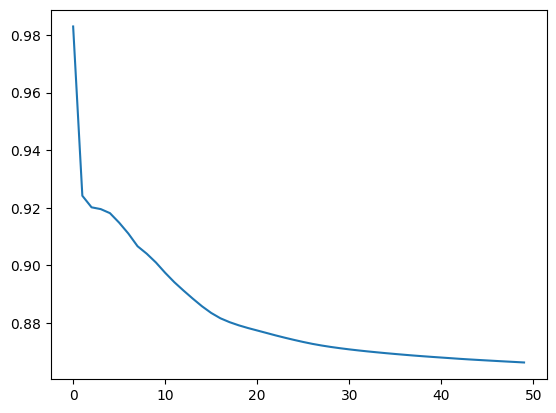

In [53]:
plt.plot(train_loss)
plt.show()

In [54]:
# output[0]

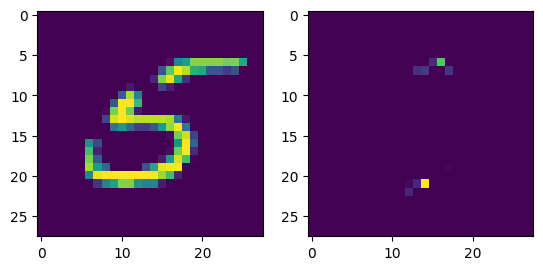

In [55]:
plt.subplot(1,2,1)
plt.imshow(output[0]['img'][0].cpu().reshape(28, 28))
plt.subplot(1,2,2)
plt.imshow(output[0]['out'].cpu().detach().numpy()[0].reshape(28,28))
plt.show()

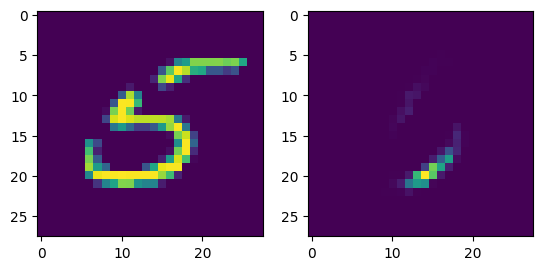

In [56]:
plt.subplot(1,2,1)
plt.imshow(output[9]['img'][0].cpu().reshape(28, 28))
plt.subplot(1,2,2)
plt.imshow(output[9]['out'].cpu().detach().numpy()[0].reshape(28,28))
plt.show()

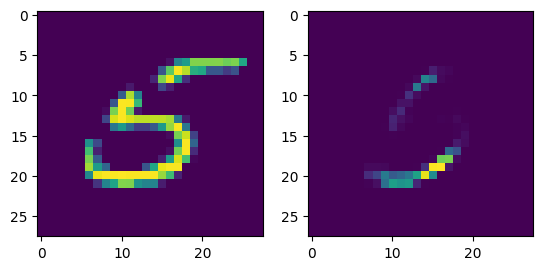

In [57]:
plt.subplot(1,2,1)
plt.imshow(output[49]['img'][0].cpu().reshape(28, 28))
plt.subplot(1,2,2)
plt.imshow(output[49]['out'].cpu().detach().numpy()[0].reshape(28,28))
plt.show()